# Description
Comparison of classification accuracy for three dog breeds - Golden Retriever, Norwegian Elkhound, and Siberian Husky - using both neural network training from scratch and transfer learning. The images used are part of the [stanford dogs dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset), which contains information on 120 dog breeds.
## 1. Requeired imports

In [ ]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Preparing data

1. Checking if GPU is avalaible.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda:0


2. Defining transformations that will be applied to each given image.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

3. Defining sizes of train, validation and test datasets.

In [ ]:
full_dataset = torchvision.datasets.ImageFolder(
    root='/content/drive/MyDrive/Data/dogs/images',
    transform=transform
)

labels = [label for _, label in full_dataset]

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f'Total size: {total_size}, train size: {train_size}, val_size: {val_size}, test_size: {test_size}')

Total size: 538, train size: 430, val_size: 53, test_size: 55


4. Splitting dataset randomly into train, validation and test datasets.

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

batch_size = 16
shuffle = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

## Creating Neural Network model from scratch
1. Defining the model used for dog breed classification.

In [ ]:
class DogClassifier(nn.Module):
    def __init__(self):
        super(DogClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)  # Change the output dimension to 3 for 3 classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. Initializing defined model.

In [ ]:
net = DogClassifier().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

3. Training created model.

In [ ]:
best_val_acc = 0.0  # Initialize the best validation accuracy
patience = 5  # Number of epochs to wait for an improvement in validation accuracy
epochs_since_improvement = 0  # Initialize the counter for epochs without improvement
epoch = 0  # Initialize the epoch counter

while epochs_since_improvement < patience:
  epoch += 1  # Increment the epoch counter

    # Training
  net.train()
  train_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = net(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)

  # Validation
  net.eval()
  val_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = net(images)
      loss = criterion(outputs, labels)

      val_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  val_loss /= len(val_loader)
  val_acc = 100 * correct / total

  print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}%, Best Val Accuracy: {:.2f}%'
          .format(epoch, train_loss, val_loss, val_acc, best_val_acc))

  # Check if validation accuracy has improved
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    epochs_since_improvement = 0
  else:
    epochs_since_improvement += 1

Epoch: 1, Train Loss: 1.0866, Val Loss: 1.0428, Val Accuracy: 39.62%, Best Val Accuracy: 0.00%
Epoch: 2, Train Loss: 1.0077, Val Loss: 0.9670, Val Accuracy: 67.92%, Best Val Accuracy: 39.62%
Epoch: 3, Train Loss: 0.9433, Val Loss: 0.8760, Val Accuracy: 75.47%, Best Val Accuracy: 67.92%
Epoch: 4, Train Loss: 0.8528, Val Loss: 0.7691, Val Accuracy: 69.81%, Best Val Accuracy: 75.47%
Epoch: 5, Train Loss: 0.8153, Val Loss: 0.7016, Val Accuracy: 71.70%, Best Val Accuracy: 75.47%
Epoch: 6, Train Loss: 0.7753, Val Loss: 0.7883, Val Accuracy: 58.49%, Best Val Accuracy: 75.47%
Epoch: 7, Train Loss: 0.6903, Val Loss: 0.7168, Val Accuracy: 66.04%, Best Val Accuracy: 75.47%
Epoch: 8, Train Loss: 0.6311, Val Loss: 0.6055, Val Accuracy: 71.70%, Best Val Accuracy: 75.47%


4. Evaluating trained model

Test Accuracy: 72.73%


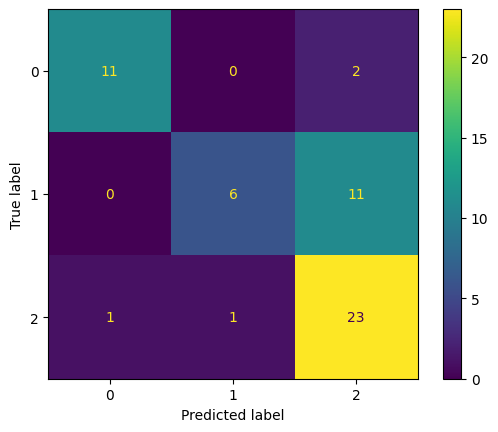

In [ ]:
net.eval()
test_correct = 0
test_total = 0

all_labels = np.array([], dtype=int)
all_predictions = np.array([], dtype=int)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Move tensors back to CPU and convert to NumPy arrays
        cpu_labels = labels.cpu().numpy()
        cpu_predicted = predicted.cpu().numpy()

        all_labels = np.concatenate((all_labels, cpu_labels))
        all_predictions = np.concatenate((all_predictions, cpu_predicted))

test_acc = 100 * test_correct / test_total
print('Test Accuracy: {:.2f}%'.format(test_acc))

# Compute and print the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)
conf_matrix_display.plot()

## 4. Using Transfer learning

**Resnet18** is a convolutional neural network that is 18 layers deep. The network is trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

1. Architecture of the Resnet18 model in PyTorch.

In [ ]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

2. Initialize pre-trained model.

In [ ]:
# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
no_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(no_features, 3)  # Change the output layer to have 3 classes - 1000 previously

# Unfreeze the last few layers for fine-tuning
unfreeze_from = "layer4"  # unfreeze from this layer onwards

for name, param in resnet18.named_parameters():
  if name.startswith(unfreeze_from):
    param.requires_grad = True

# Move the model to a specified device, which can be a CPU or a GPU.
resnet18.to(device)

criterion = nn.CrossEntropyLoss()
# Compute gradient only for unfreezed layers 
trainable_params = [param for param in resnet18.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(trainable_params, lr=0.001)

3. Architecture of the Resnet18 model in PyTorch after changes.

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

4. Train the model to classify dogs breeds.

In [ ]:
best_val_acc = 0.0  # Initialize the best validation accuracy
patience = 5  # Number of epochs to wait for an improvement in validation accuracy
epochs_since_improvement = 0  # Initialize the counter for epochs without improvement
epoch = 0  # Initialize the epoch counter

while epochs_since_improvement < patience:
  epoch += 1

  # Training
  resnet18.train()
  train_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  
  train_loss /= len(train_loader)

  # Validation
  resnet18.eval()
  val_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = resnet18(images)
      loss = criterion(outputs, labels)

      val_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  val_loss /= len(val_loader)
  val_acc = 100 * correct / total

  print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}%, Best Val Accuracy: {:.2f}%'
        .format(epoch, train_loss, val_loss, val_acc, best_val_acc))

  # Check if validation accuracy has improved
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    epochs_since_improvement = 0
  else:
    epochs_since_improvement += 1

Epoch: 1, Train Loss: 1.1070, Val Loss: 0.8451, Val Accuracy: 62.26%, Best Val Accuracy: 0.00%
Epoch: 2, Train Loss: 0.7835, Val Loss: 0.6277, Val Accuracy: 77.36%, Best Val Accuracy: 62.26%
Epoch: 3, Train Loss: 0.6197, Val Loss: 0.5302, Val Accuracy: 84.91%, Best Val Accuracy: 77.36%
Epoch: 4, Train Loss: 0.4985, Val Loss: 0.4186, Val Accuracy: 90.57%, Best Val Accuracy: 84.91%
Epoch: 5, Train Loss: 0.4270, Val Loss: 0.3866, Val Accuracy: 92.45%, Best Val Accuracy: 90.57%
Epoch: 6, Train Loss: 0.3678, Val Loss: 0.3090, Val Accuracy: 94.34%, Best Val Accuracy: 92.45%
Epoch: 7, Train Loss: 0.3250, Val Loss: 0.3172, Val Accuracy: 94.34%, Best Val Accuracy: 94.34%
Epoch: 8, Train Loss: 0.3141, Val Loss: 0.3013, Val Accuracy: 96.23%, Best Val Accuracy: 94.34%
Epoch: 9, Train Loss: 0.2776, Val Loss: 0.2756, Val Accuracy: 96.23%, Best Val Accuracy: 96.23%
Epoch: 10, Train Loss: 0.2603, Val Loss: 0.2253, Val Accuracy: 96.23%, Best Val Accuracy: 96.23%
Epoch: 11, Train Loss: 0.2336, Val Loss:

3. Definig train sizes 

Test Accuracy: 94.55%


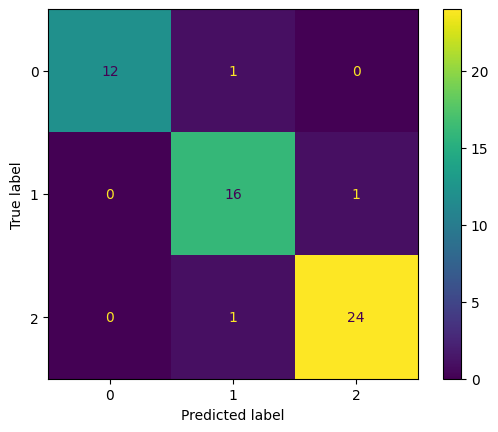

In [ ]:
resnet18.eval()
test_correct = 0
test_total = 0

all_labels = np.array([], dtype=int)
all_predictions = np.array([], dtype=int)

with torch.no_grad():
  # Test
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

    cpu_labels = labels.cpu().numpy()
    cpu_predicted = predicted.cpu().numpy()

    all_labels = np.concatenate((all_labels, cpu_labels))
    all_predictions = np.concatenate((all_predictions, cpu_predicted))

test_acc = 100 * test_correct / test_total
print('Test Accuracy: {:.2f}%'.format(test_acc))

# Compute and print the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)
conf_matrix_display.plot()